In [21]:
import pandas as pd
import numpy as np
import requests
import json
from pandas.io.json import json_normalize
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [2]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
wiki_df = pd.read_html(website_url)[0]
wiki_df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [178]:
wiki_df.shape

(288, 3)

In [3]:
wiki_df1 = wiki_df[wiki_df['Borough']!="Not assigned"].reset_index(drop=True)
wiki_df1.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [4]:
wiki_df1['Neighbourhood'] = wiki_df1[['Postcode','Borough','Neighbourhood']].groupby(['Postcode','Borough'])['Neighbourhood'].transform(lambda x: ','.join(x))
wiki_df2 = wiki_df1[['Postcode','Borough','Neighbourhood']].drop_duplicates().reset_index(drop=True)
wiki_df2.head()
n = np.shape(wiki_df2)

In [5]:
for i in range(n[0]):
    if wiki_df2['Neighbourhood'][i] == "Not assigned":
        wiki_df2['Neighbourhood'][i] = wiki_df2['Borough'][i]
wiki_df2.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront,Regent Park"
3,M6A,North York,"Lawrence Heights,Lawrence Manor"
4,M7A,Queen's Park,Queen's Park


In [6]:
post_codes_lat_long = pd.read_csv('Geospatial_Coordinates.csv')

In [7]:
wiki_df2 = wiki_df2.join(post_codes_lat_long.set_index('Postal Code'), on='Postcode')

In [180]:
wiki_df2.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights,Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


In [8]:
CLIENT_ID = '2T5V12BJ4EGZXCFLEZ1CNN5T12DIOBXTFQ4CU2VTNHI3ZKUH' # your Foursquare ID
CLIENT_SECRET = '2IOCW5XEEQWYJ2H0EP14DXBF4VZUXAPJLZXS4K4DDDMSJWUH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2T5V12BJ4EGZXCFLEZ1CNN5T12DIOBXTFQ4CU2VTNHI3ZKUH
CLIENT_SECRET:2IOCW5XEEQWYJ2H0EP14DXBF4VZUXAPJLZXS4K4DDDMSJWUH


In [9]:
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

In [12]:
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
 
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
 

In [13]:
toronto_data=wiki_df2
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

In [181]:
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Parkwoods,43.753259,-79.329656,GreenWin pool,43.756232,-79.333842,Pool
4,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena


In [29]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.head()
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()     

In [182]:
toronto_grouped.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,King,Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,"Alderwood,Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [25]:
with open('nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [26]:
neighborhoods_data = newyork_data['features']

In [27]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

In [28]:
# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough']
    neighborhood_name = data['properties']['name']       
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [35]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [37]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
newyork_venues = getNearbyVenues(names= neighborhoods['Neighborhood'],
                                   latitudes= neighborhoods['Latitude'],
                                   longitudes= neighborhoods['Longitude']
                                  )



Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [40]:
newyork_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,28,28,28,28,28,28
Annadale,9,9,9,9,9,9
Arden Heights,5,5,5,5,5,5
Arlington,6,6,6,6,6,6
Arrochar,17,17,17,17,17,17
Arverne,17,17,17,17,17,17
Astoria,100,100,100,100,100,100
Astoria Heights,13,13,13,13,13,13
Auburndale,19,19,19,19,19,19


In [41]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood']
# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]
newyork_onehot.head()
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
newyork_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,...,Warehouse Store,Waste Facility,Watch Shop,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Allerton,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Annadale,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.111111,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Arden Heights,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Arlington,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.166667,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Arrochar,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Arverne,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000
6,Astoria,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000
7,Astoria Heights,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Auburndale,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.052632,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Bath Beach,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739


#### USecase 1: If a person is residing in Toronta and wants to migrate to NEw york. 
####    He/She is looking to similar city in New york like their residing city in Tornoto. 
####    Below algorithm will give them the name of cities.

In [54]:
toronto_grouped.columns.values

array(['Neighbourhood', 'Accessories Store', 'Adult Boutique',
       'Afghan Restaurant', 'Airport', 'Airport Food Court',
       'Airport Gate', 'Airport Lounge', 'Airport Service',
       'Airport Terminal', 'American Restaurant', 'Antique Shop',
       'Aquarium', 'Argentinian Restaurant', 'Art Gallery', 'Art Museum',
       'Arts & Crafts Store', 'Asian Restaurant', 'Athletics & Sports',
       'Auto Garage', 'Auto Workshop', 'BBQ Joint', 'Baby Store',
       'Bagel Shop', 'Bakery', 'Bank', 'Bar', 'Baseball Field',
       'Baseball Stadium', 'Basketball Court', 'Basketball Stadium',
       'Beach', 'Beer Bar', 'Beer Store', 'Belgian Restaurant',
       'Bike Shop', 'Bistro', 'Board Shop', 'Boat or Ferry', 'Bookstore',
       'Boutique', 'Bowling Alley', 'Brazilian Restaurant',
       'Breakfast Spot', 'Brewery', 'Bridal Shop', 'Bubble Tea Shop',
       'Building', 'Burger Joint', 'Burrito Place', 'Bus Line',
       'Bus Station', 'Bus Stop', 'Business Service', 'Butcher',
       '

In [47]:
toronto_grouped.shape

(101, 280)

In [48]:
newyork_grouped.shape

(301, 428)

#### This person lives in Adelaide,King,Richmond has preference for 
#### Bank, Bar, Church, Department Store, Kids store, Pool, Supermarket, Train

In [75]:
Toronto_selected = toronto_grouped[['Neighbourhood','Bank', 'Bar','Church','Department Store', 'Kids Store', 'Pool','Supermarket','Train Station']]
toronto_place = Toronto_selected[Toronto_selected['Neighbourhood'] == 'Adelaide,King,Richmond']

In [74]:
Toronto_selected.head()

,Neighbourhood,Bank,Bar,Church,Department Store,Kids Store,Pool,Supermarket,Train Station
0,"Adelaide,King,Richmond",0.0,0.03,0.0,0.01,0.0,0.0,0.0,0.0
1,Agincourt,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
4,"Alderwood,Long Branch",0.0,0.00,0.0,0.00,0.0,0.1,0.0,0.0


In [64]:
del newyork_selected

In [71]:
newyork_selected = newyork_grouped[['Neighborhood','Bank', 'Bar','Church','Department Store', 'Kids Store', 'Pool','Supermarket','Train Station']]

In [81]:
newyork_knn = newyork_selected.drop(['Neighborhood'], axis=1)

#### Use KNN to get the 5 similar new york cities

In [69]:
Toronto_selected['Neighborhood']

0      0.010000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.000000
7      0.000000
8      0.000000
9      0.000000
10     0.000000
11     0.000000
12     0.000000
13     0.000000
14     0.000000
15     0.000000
16     0.000000
17     0.000000
18     0.000000
19     0.000000
20     0.000000
21     0.000000
22     0.000000
23     0.000000
24     0.000000
25     0.000000
26     0.000000
27     0.000000
28     0.000000
29     0.000000
         ...   
71     0.000000
72     0.000000
73     0.000000
74     0.000000
75     0.000000
76     0.000000
77     0.000000
78     0.000000
79     0.000000
80     0.000000
81     0.000000
82     0.000000
83     0.000000
84     0.026316
85     0.000000
86     0.200000
87     0.000000
88     0.000000
89     0.000000
90     0.000000
91     0.000000
92     0.000000
93     0.000000
94     0.000000
95     0.000000
96     0.000000
97     0.000000
98     0.000000
99     0.000000
100    0.000000
Name: Neighborhood, Leng

In [83]:
toronto_place.head()
toronto_knn  = toronto_place.drop(['Neighbourhood'],axis=1)

In [78]:
from sklearn.neighbors import NearestNeighbors

In [86]:
neigh = NearestNeighbors(n_neighbors=5)

In [87]:
neigh.fit(newyork_knn) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [88]:
print(neigh.kneighbors(toronto_knn)) 

(array([[0.01      , 0.01      , 0.01000459, 0.01054093, 0.01151751]]), array([[ 50,  95,  23, 164, 281]], dtype=int64))


In [94]:
print(newyork_selected.iloc[50])
print(newyork_selected.iloc[95])
print(newyork_selected.iloc[23])
print(newyork_selected.iloc[164])
print(newyork_selected.iloc[281])

Neighborhood        Chinatown
Bank                        0
Bar                      0.03
Church                      0
Department Store            0
Kids Store                  0
Pool                        0
Supermarket                 0
Train Station               0
Name: 50, dtype: object
Neighborhood        Financial District
Bank                                 0
Bar                               0.03
Church                               0
Department Store                     0
Kids Store                           0
Pool                                 0
Supermarket                          0
Train Station                        0
Name: 95, dtype: object
Neighborhood        Bensonhurst
Bank                          0
Bar                    0.030303
Church                        0
Department Store              0
Kids Store                    0
Pool                          0
Supermarket                   0
Train Station                 0
Name: 23, dtype: object
Neighborhood       

In [ ]:
### USecase For business owners - Shushi Restaurant in Toronto

In [95]:
toronto_grouped.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,King,Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,"Alderwood,Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


#### A tourist id trsvelling to Battery Park City in New York snd wants to see top places or venues of it.

In [101]:
sortt = newyork_grouped[newyork_grouped['Neighborhood']=='Battery Park City'].T.reset_index()
sortt.head()
temp=sortt.iloc[1:]
temp.columns=['venue','freq']
temp.head()

top_venues = temp.sort_values(by=['freq'], ascending=False).head()
top_venues.head(10)


,venue,freq
284,Park,0.07
86,Coffee Shop,0.07
195,Hotel,0.05
174,Gym,0.04
425,Wine Shop,0.03


#### Cluster the neighborhoods of two cities based upon the similarity using K-means Algorithm.

In [105]:
Toronto_cluster_data = toronto_grouped[['Bank', 'Bar','Church','Department Store', 'Kids Store', 'Pool','Supermarket','Train Station','Office','Museum','Pool']]

In [106]:
Newyork_cluster_data = newyork_grouped[['Bank', 'Bar','Church','Department Store', 'Kids Store', 'Pool','Supermarket','Train Station','Office','Museum','Pool']]

In [107]:
frames = [Toronto_cluster_data, Newyork_cluster_data]

cluster_data = pd.concat(frames)

In [108]:
cluster_data.head()

,Bank,Bar,Church,Department Store,Kids Store,Pool,Supermarket,Train Station,Office,Museum,Pool
0,0.0,0.03,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0
1,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,0.00,0.0,0.00,0.0,0.1,0.0,0.0,0.00,0.0,0.1


In [111]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(cluster_data)
 
# check cluster labels generated for each row in the dataframe
kmeans.labels_
 


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

#### Exploratory Data Analysis

In [124]:
df = newyork_grouped[['Neighborhood','Bank']]
df.head()

top_venues = df.sort_values(by=['Bank'], ascending=False).head(15)
top_venues.head(20)


,Neighborhood,Bank
28,Borough Park,0.150000
230,Richmond Valley,0.142857
45,Castle Hill,0.142857
216,Prince's Bay,0.142857
136,Huguenot,0.142857
220,Queens Village,0.125000
243,Schuylerville,0.111111
256,Spuyten Duyvil,0.100000
232,Riverdale,0.100000
146,Kew Gardens Hills,0.100000


In [130]:
top_venues.reset_index(drop=True, inplace=True)






In [131]:
top_venues.head()

,Neighborhood,Bank
0,Borough Park,0.150000
1,Richmond Valley,0.142857
2,Castle Hill,0.142857
3,Prince's Bay,0.142857
4,Huguenot,0.142857


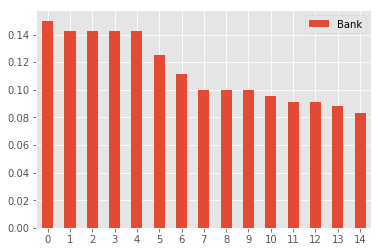

In [151]:
#top_venues.plot(kind='bar', figsize=(10,6))
#df = pd.DataFrame(top_venues['Neighborhood'],top_venues['Bank'], index=top_venues['Neighborhood'])

df = pd.DataFrame({'Neighborhood': top_venues['Neighborhood'],'Bank': top_venues['Bank']})



ax = df.plot.bar(rot=0)

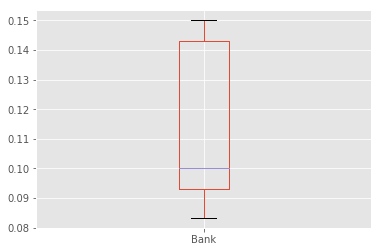

In [153]:
boxplot = top_venues.boxplot(column=['Bank'])

In [155]:
df = newyork_grouped[['Neighborhood','Supermarket']]
df.head()

top_venues = df.sort_values(by=['Supermarket'], ascending=False).head(15)
top_venues.head(20)


,Neighborhood,Supermarket
115,Graniteville,0.500000
131,Holliswood,0.250000
84,Edenwald,0.200000
203,Olinville,0.166667
185,Mount Hope,0.142857
252,South Jamaica,0.125000
62,Concord,0.125000
208,Parkchester,0.114286
213,Pomonok,0.090909
180,Morris Heights,0.083333


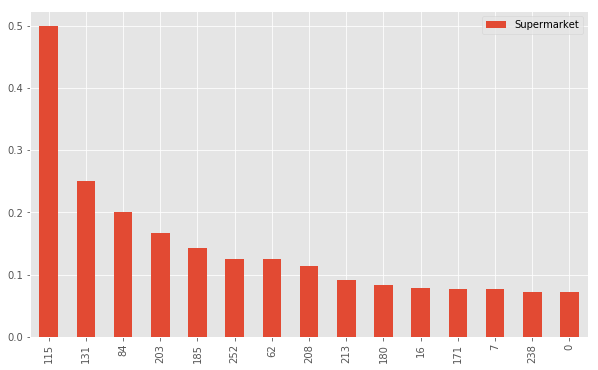

In [156]:
top_venues.plot(kind='bar', figsize=(10,6))

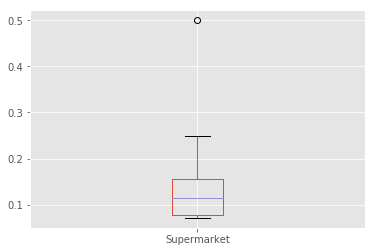

In [157]:
boxplot = top_venues.boxplot(column=['Supermarket'])

In [161]:

df = newyork_grouped[['Neighborhood','Train Station']]
df.head()

top_venues = df.sort_values(by=['Train Station'], ascending=False).head(15)
top_venues.head(20)



,Neighborhood,Train Station
230,Richmond Valley,0.142857
136,Huguenot,0.142857
149,Laurelton,0.125000
1,Annadale,0.111111
56,Clifton,0.111111
119,Great Kills,0.058824
189,New Dorp,0.041667
71,Dongan Hills,0.041667
297,Woodlawn,0.038462
16,Bedford Park,0.026316


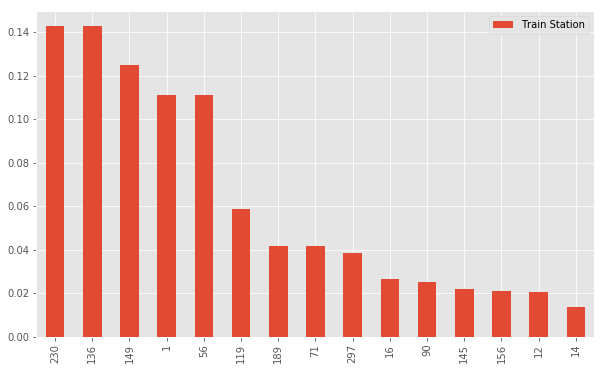

In [162]:
top_venues.plot(kind='bar', figsize=(10,6))


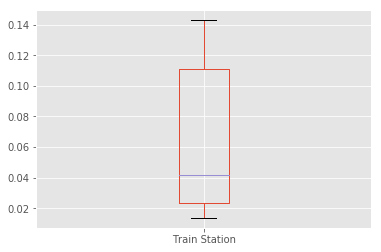

In [163]:
boxplot = top_venues.boxplot(column=['Train Station'])

In [183]:
df = toronto_grouped[['Neighbourhood','Bank']]
df.head()

top_venues = df.sort_values(by=['Bank'], ascending=False).head(15)
top_venues.head(20)


,Neighbourhood,Bank
26,"Cloverdale,Islington,Martin Grove,Princess Gar...",1.000000
100,York Mills West,0.500000
6,Bayview Village,0.250000
38,Downsview West,0.250000
18,Cedarbrae,0.125000
98,"Woodbine Gardens,Parkview Hill",0.076923
72,"Parkdale,Roncesvalles",0.062500
91,Thorncliffe Park,0.058824
5,"Bathurst Manor,Downsview North,Wilson Heights",0.052632
35,"Dovercourt Village,Dufferin",0.047619


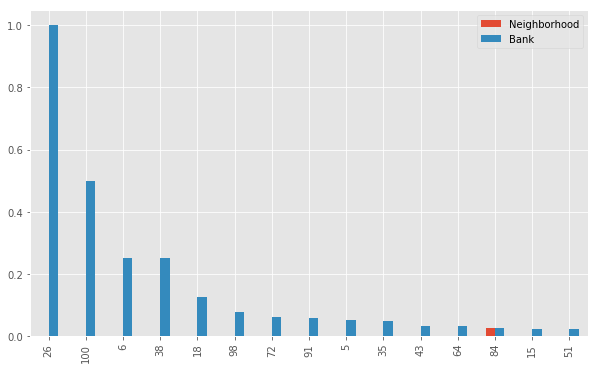

In [165]:
top_venues.plot(kind='bar', figsize=(10,6))

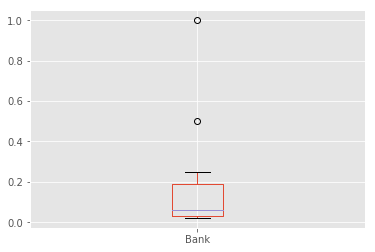

In [166]:
boxplot = top_venues.boxplot(column=['Bank'])

In [173]:

df = toronto_grouped[['Neighbourhood','Train Station']]
df.head()

top_venues = df.sort_values(by=['Train Station'], ascending=False).head(15)
top_venues.head(20)



,Neighbourhood,Train Station
50,"Harbourfront East,Toronto Islands,Union Station",0.01
32,"Design Exchange,Toronto Dominion Centre",0.01
44,"First Canadian Place,Underground city",0.01
64,Leaside,0.00
73,Parkwoods,0.00
72,"Parkdale,Roncesvalles",0.00
71,"Northwood Park,York University",0.00
70,Northwest,0.00
69,North Toronto West,0.00
68,"Newtonbrook,Willowdale",0.00


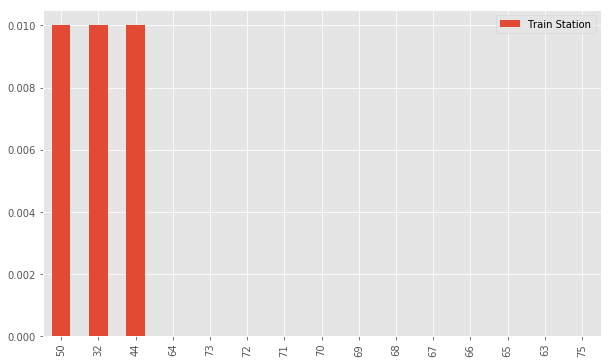

In [174]:
top_venues.plot(kind='bar', figsize=(10,6))

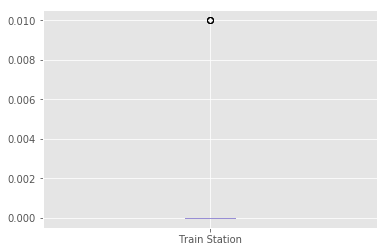

In [175]:
boxplot = top_venues.boxplot(column=['Train Station'])

In [176]:

df = toronto_grouped[['Neighbourhood','Supermarket']]
df.head()

top_venues = df.sort_values(by=['Supermarket'], ascending=False).head(15)
top_venues.head(20)



,Neighbourhood,Supermarket
35,"Dovercourt Village,Dufferin",0.095238
30,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",0.071429
91,Thorncliffe Park,0.058824
5,"Bathurst Manor,Downsview North,Wilson Heights",0.052632
64,Leaside,0.031250
50,"Harbourfront East,Toronto Islands,Union Station",0.010000
65,"Little Portugal,Trinity",0.000000
73,Parkwoods,0.000000
72,"Parkdale,Roncesvalles",0.000000
71,"Northwood Park,York University",0.000000


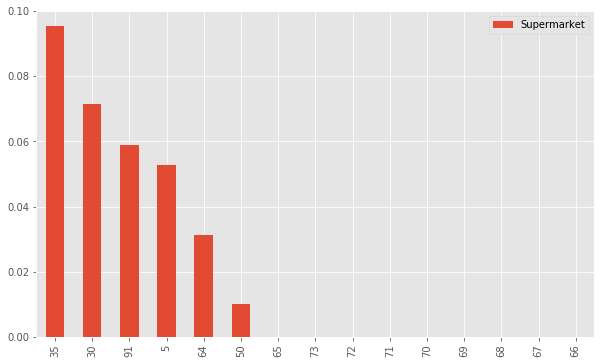

In [177]:
top_venues.plot(kind='bar', figsize=(10,6))